# Проект "Информационная безопасность"

Компания онлайн-сервис с высоким уровнем входящего трафика имеет специализированный отдел безопасности, который занимается фильтрацией и анализом трафика. Сотрудники этого отдела обратились за помощью в автоматизации выявления аномального и злонамеренного трафика. 

Цель проекта: разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный, включая следующие типы атак: DDoS, SQL-инъекции, брутфорс, вредоносные программы и т.д.

## 1.Исследовательский анализ данных

### Загрузка библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### Анализ и предобработка данных

In [2]:
data = pd.read_csv('network_traffic_data.csv')

In [3]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

In [4]:
def data_info(df):
    print("Первые 10 строк датафрейма")
    display(df.head(10))
    print()
    print("Информация о датафрейме")
    print(df.info())
    print()
    print("Тип данных в каждом столбце датафрейма")
    print(df.dtypes)
    print()
    print("Количество пропусков в каждом столбце датафрейма")
    print(df.isna().sum())
    print("Доля пропусков в каждом столбце датафрейма")
    print(df.isna().mean()*100)
    print()
    print("Статистические характеристики данных")
    print(df.describe())
    print()
    print("Количество явных дубликатов")
    print(df.duplicated().sum())

In [5]:
data_info(data)

Первые 10 строк датафрейма


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,5480074,3,1,12,0,6,0,4.000,3.465,0,0,0.0,0.0,2.189751,0.729917,1.826691e+06,3.131700e+06,5442804,101,5480074,2740037.000,3.822290e+06,5442804,37270,0,0.000,0.00,0,0,0,0,0,0,72,32,0.547438,0.182479,0,6,2.40,3.287,10.80000,0,0,0,1,0,0,0,0,0,3.00,4.000,0.0,72,0,0,0,0,0,0,3,12,1,0,8192,42780,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,443,711977,9,10,703,3950,267,0,78.100,103.300,1448,0,395.0,587.5,6535.323473,26.686255,3.955428e+04,5.015462e+04,120501,1,616301,77037.625,7.299598e+04,215614,230,616874,68541.555,71985.97,199836,1,0,0,0,0,296,328,12.640858,14.045398,0,1448,232.60,442.800,196012.66000,0,0,0,1,0,0,0,0,1,244.90,78.100,395.0,296,0,0,0,0,0,0,9,703,10,3950,29200,252,4,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,53,153398,2,2,80,224,40,40,40.000,0.000,112,112,112.0,0.0,1981.772904,26.075959,5.113267e+04,8.855831e+04,153391,3,3,3.000,0.000000e+00,3,3,4,4.000,0.00,4,4,0,0,0,0,40,40,13.037980,13.037980,40,112,68.80,39.440,1555.20000,0,0,0,0,0,0,0,0,1,86.00,40.000,112.0,40,0,0,0,0,0,0,2,80,2,224,-1,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,53,57660,1,1,46,128,46,46,46.000,0.000,128,128,128.0,0.0,3017.689906,34.686091,5.766000e+04,0.000000e+00,57660,57660,0,0.000,0.000000e+00,0,0,0,0.000,0.00,0,0,0,0,0,0,20,20,17.343046,17.343046,46,128,73.30,47.340,2241.33330,0,0,0,0,0,0,0,0,1,110.00,46.000,128.0,20,0,0,0,0,0,0,1,46,1,128,-1,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,8446,767,3,1,43,6,31,6,14.336,14.440,6,6,6.0,0.0,63885.267280,5215.123859,2.556667e+02,3.942896e+02,710,3,713,356.500,4.999245e+02,710,3,0,0.000,0.00,0,0,0,0,0,0,60,20,3911.342800,1303.781000,6,31,11.00,11.180,125.00000,0,0,0,0,1,0,0,0,0,13.75,14.336,6.0,60,0,0,0,0,0,0,3,43,1,6,1017,0,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
5,47210,3,2,0,0,0,0,0,0.000,0.000,0,0,0.0,0.0,0.000000,666666.666700,3.000000e+00,0.000000e+00,3,3,3,3.000,0.000000e+00,3,3,0,0.000,0.00,0,0,0,0,0,0,64,0,666666.700000,0.000000,0,0,0.00,0.000,0.00000,0,0,0,0,1,0,0,0,0,0.00,0.000,0.0,64,0,0,0,0,0,0,2,0,0,0,361,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6,53,111373,4,2,168,116,42,42,42.000,0.000,58,58,58.0,0.0,2549.989674,53.873021,2.227460e+04,3.493425e+04,79780,3,31590,10530.000,1.823330e+04,31584,3,3,3.000,0.00,3,3,0,0,0,0,104,64,35.915348,17.957674,42,58,46.56,7.810,60.95238,0,0,0,0,0,0,0,0,0,54.34,42.000,58.0,104,0,0,0,0,0,0,4,168,2,116,-1,-1,3,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7,443,65786373,122,191,23544,275883,1093,0,193.000,366.200,4380,0,1444.0,689.0,4551.504914,4.757824,2.108538e+05,2.919396e+06,51185854,1,65786373,543689.060,4.680394e+06,51185854,1,14585289,76764.680,484025.84,4827482,1,0,0,0,0,2464,3832,1.854487,2.903337,0,4380,953.50,846.000,715368.30000,0,0,0,1,0,0,0,0,1,956.50,193.000,1444.0,2464,0,0,0,0,0,0,122,23


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             539616 non-null  int64  
 1    Flow Duration                539616 non-null  int64  
 2    Total Fwd Packets            539616 non-null  int64  
 3    Total Backward Packets       539616 non-null  int64  
 4   Total Length of Fwd Packets   539616 non-null  int64  
 5    Total Length of Bwd Packets  539616 non-null  int64  
 6    Fwd Packet Length Max        539616 non-null  int64  
 7    Fwd Packet Length Min        539616 non-null  int64  
 8    Fwd Packet Length Mean       539616 non-null  float64
 9    Fwd Packet Length Std        539616 non-null  float64
 10  Bwd Packet Length Max         539616 non-null  int64  
 11   Bwd Packet Length Min        539616 non-null  int64  
 12   Bwd Packet Length 

In [6]:
#приведем столбцы к необходимому виду
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('/', '_')

In [7]:
data.columns

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes_s', 'flow_packets_s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets_s', 'bwd_packets_s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_co

In [8]:
#приведем метки к необходимому виду
data['label'] = data['label'].str.lower().str.replace(' ', '_').str.replace('�', '').str.replace('__', '_')

In [9]:
data['label'].value_counts()

benign                      240000
dos_hulk                    115974
portscan                     79660
ddos                         64366
dos_goldeneye                10293
ftp-patator                   7938
ssh-patator                   5897
dos_slowloris                 5796
dos_slowhttptest              5499
bot                           1966
web_attack_brute_force        1507
web_attack_xss                 652
infiltration                    36
web_attack_sql_injection        21
heartbleed                      11
Name: label, dtype: int64

In [10]:
#LabelEncoder для целевого признака
le = preprocessing.LabelEncoder()
data['label'] = le.fit_transform(data['label'])

In [11]:
#удалим дубликаты
data = data.drop_duplicates()

In [12]:
#удалим данные с пропусками
data = data.dropna()

In [13]:
#заменим inf на максимальные значения
max_value = np.nanmax(data['flow_bytes_s'][data['flow_bytes_s']!=np.inf])
data['flow_bytes_s'] = data['flow_bytes_s'].replace([np.inf, -np.inf], max_value)
data['flow_packets_s'] = data['flow_packets_s'].replace([np.inf, -np.inf], max_value)

In [14]:
#посторим графики распределения по данным датасета
def data_hist(col):
    data[col].hist(bins=100)
    plt.title(col)
    plt.xlabel('Значение')
    plt.ylabel('частота')
    plt.show()

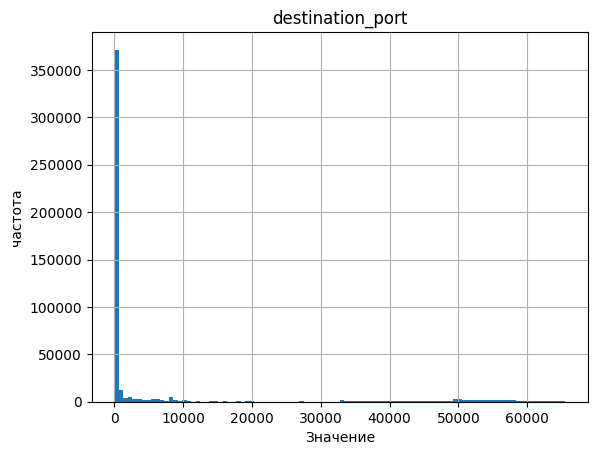

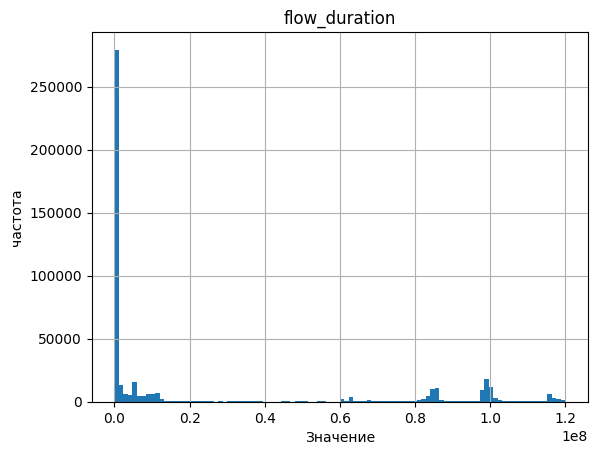

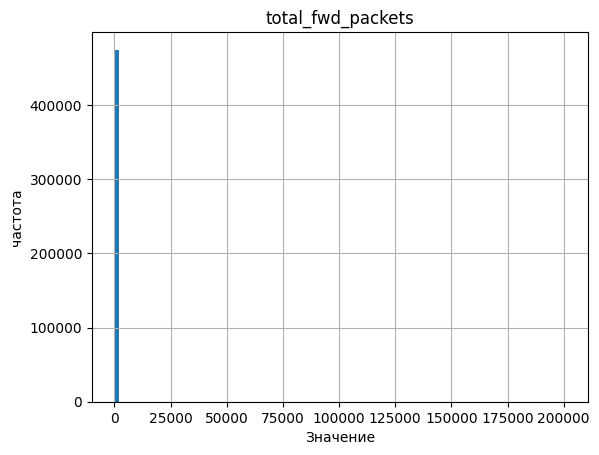

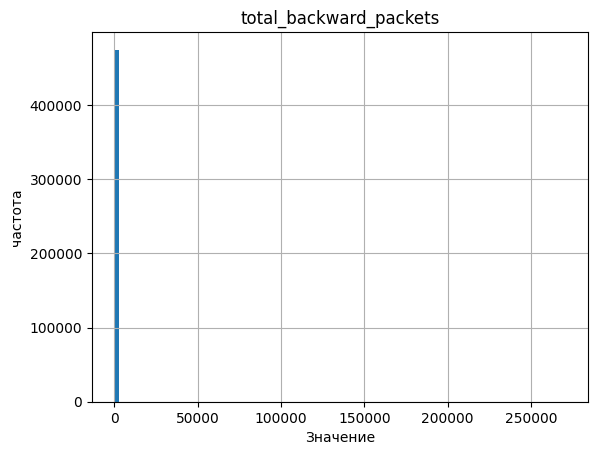

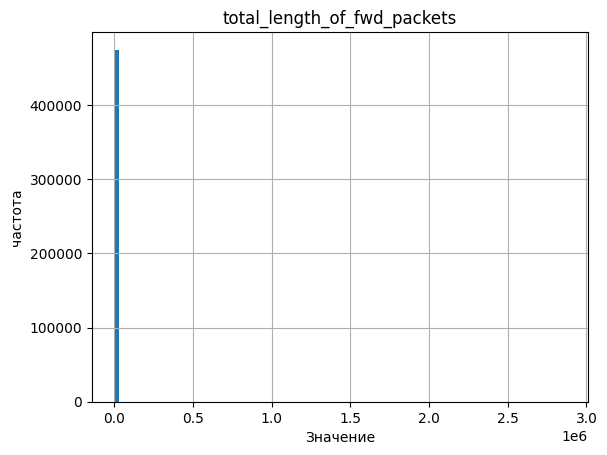

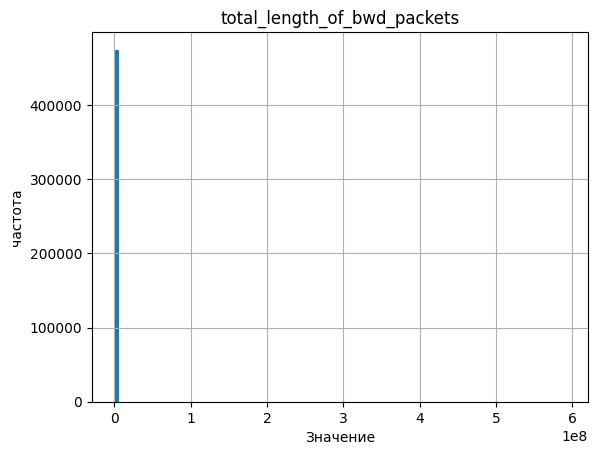

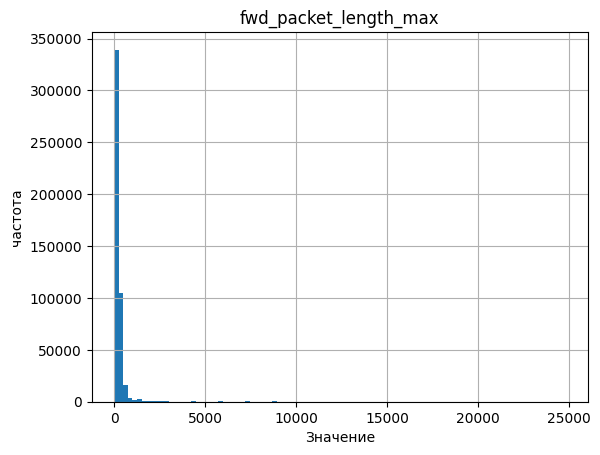

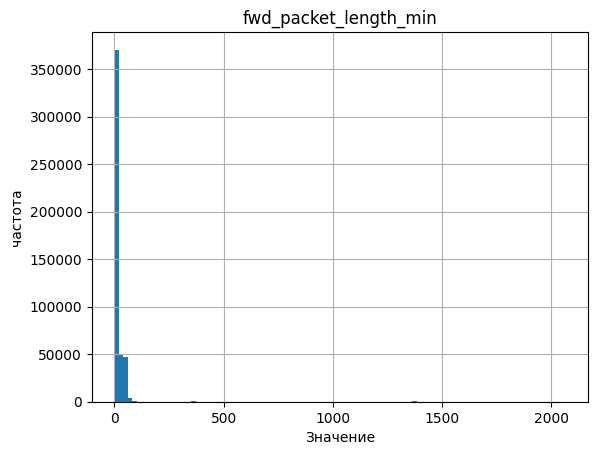

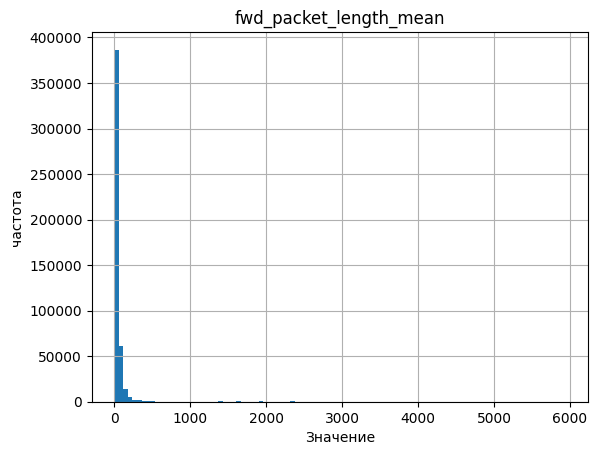

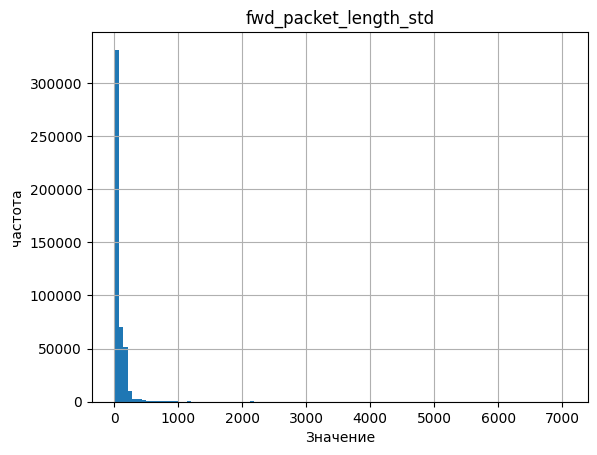

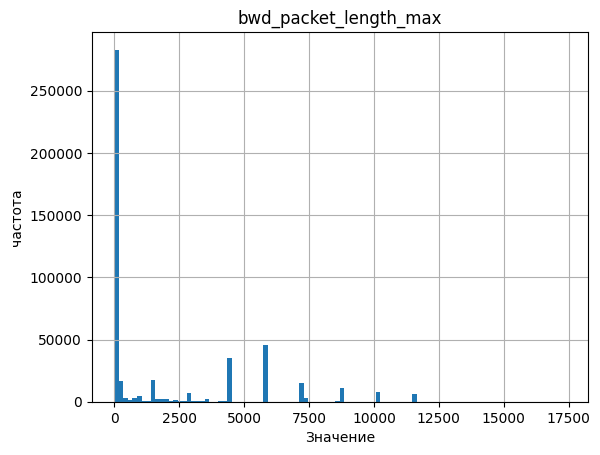

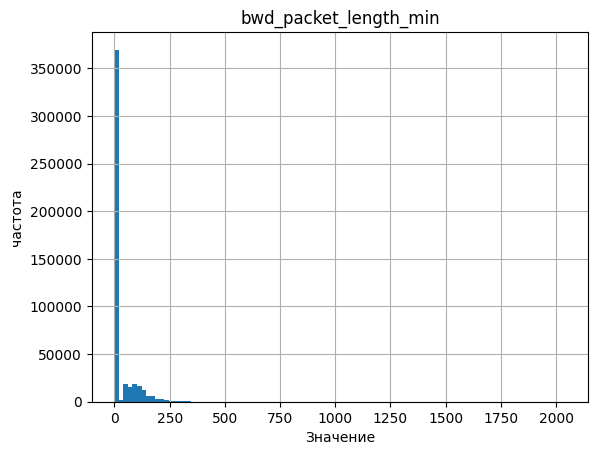

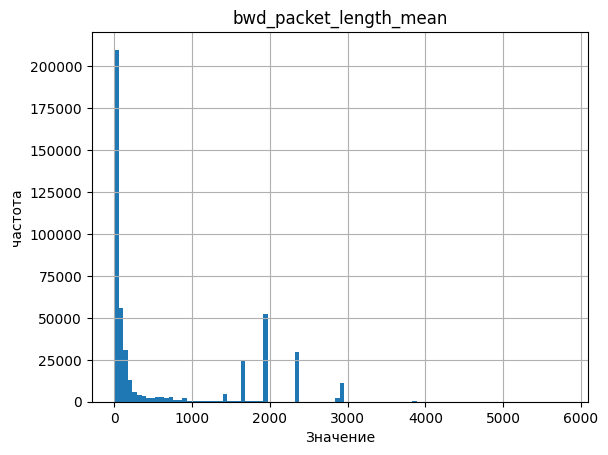

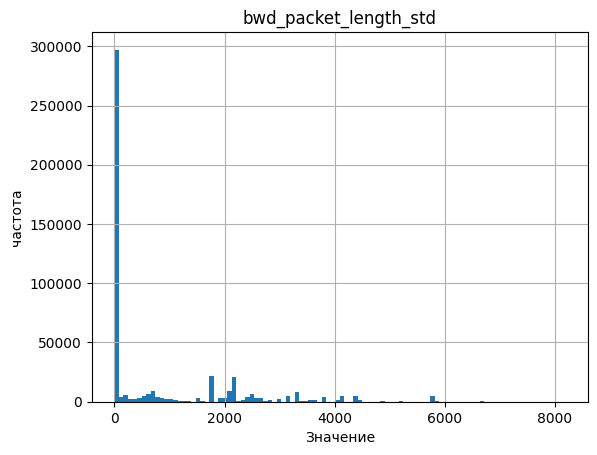

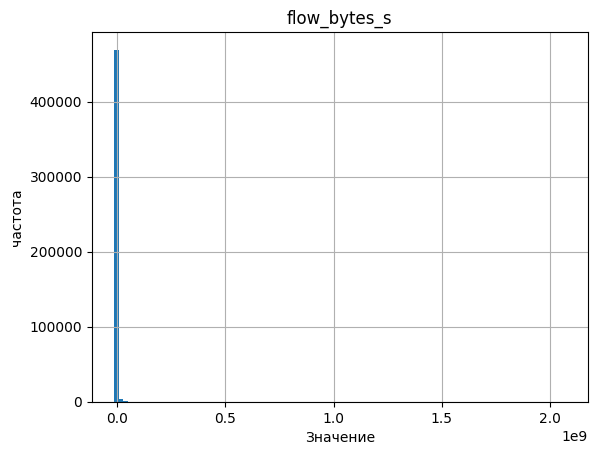

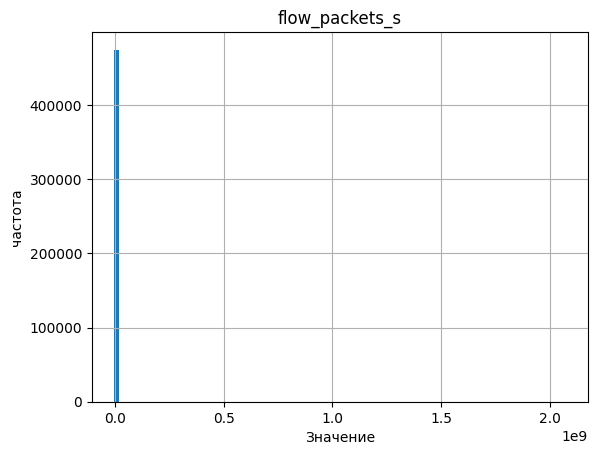

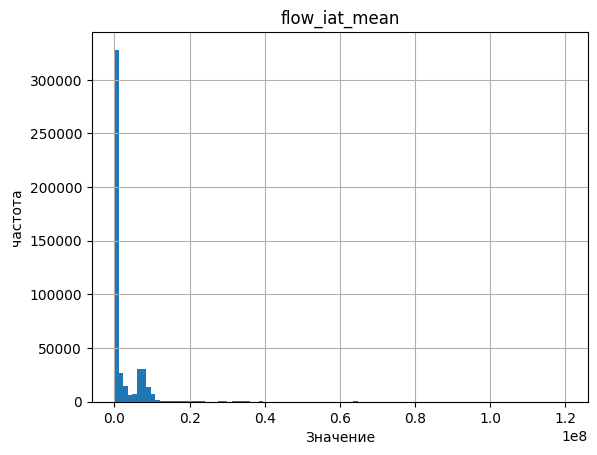

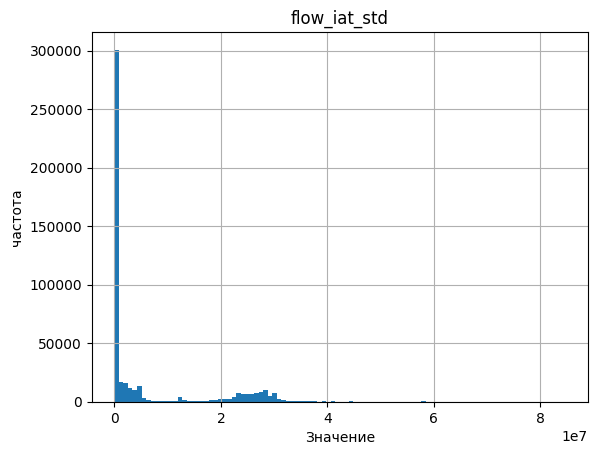

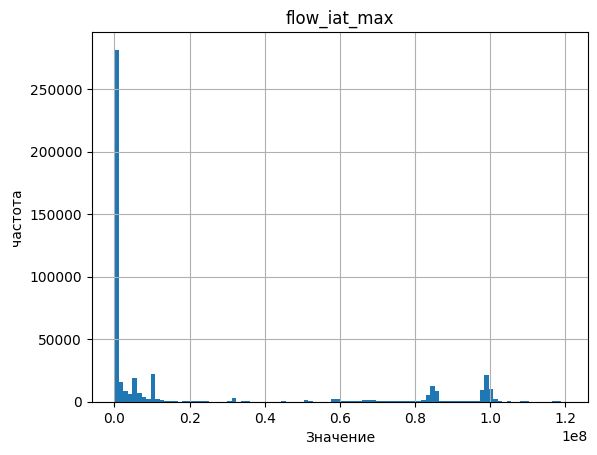

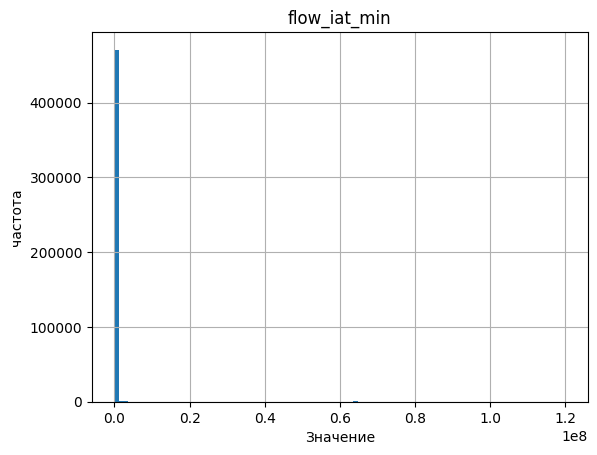

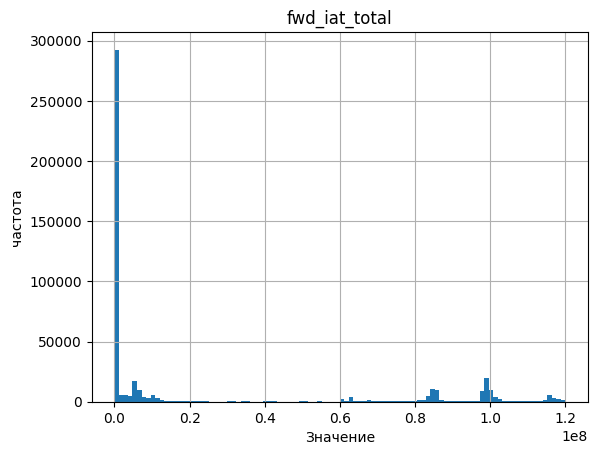

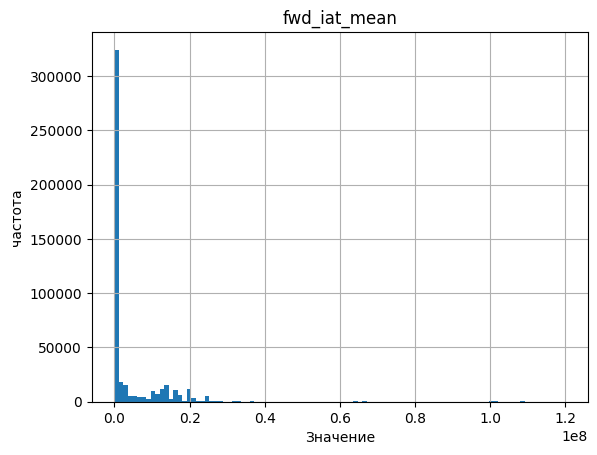

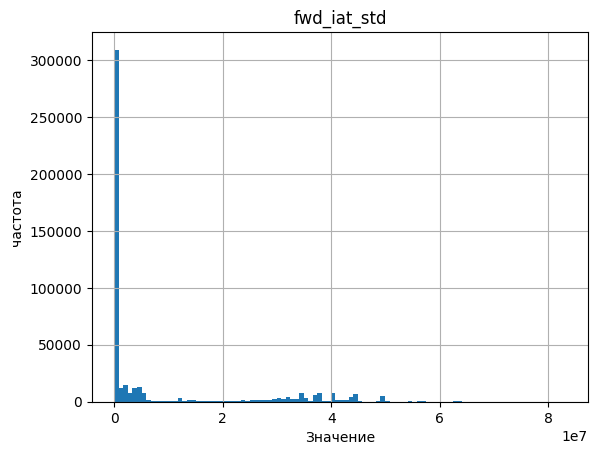

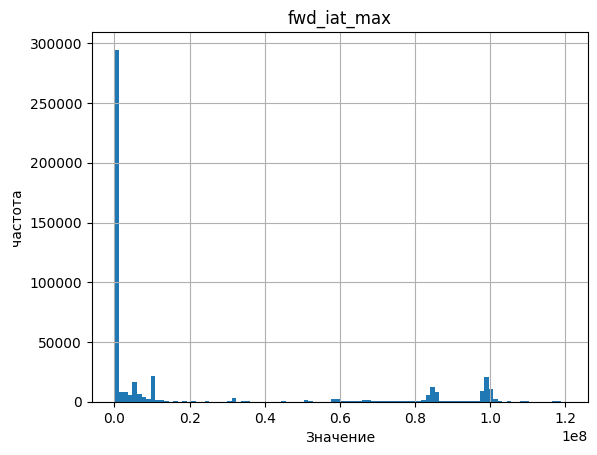

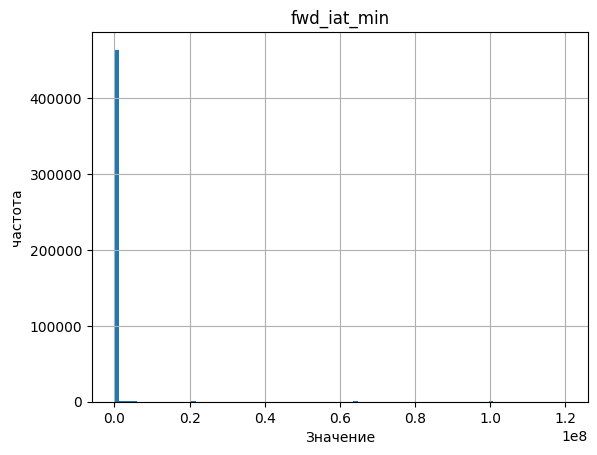

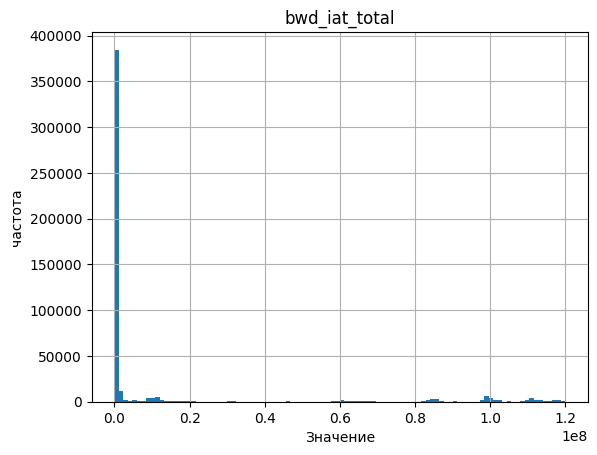

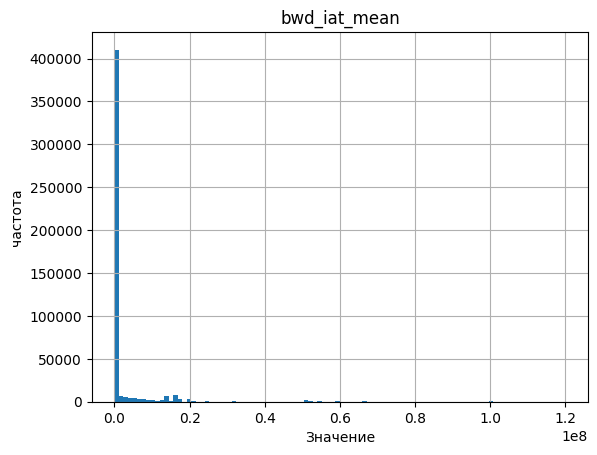

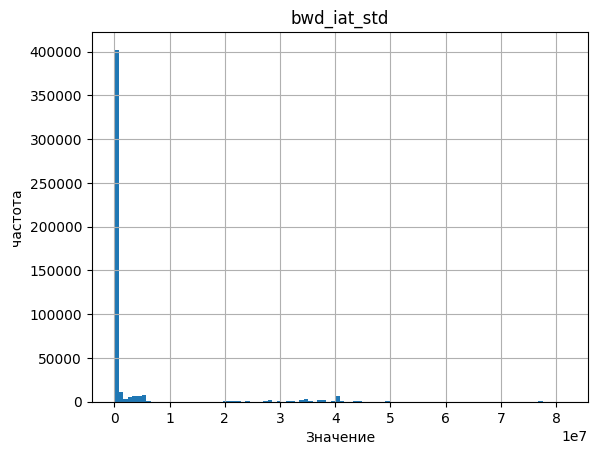

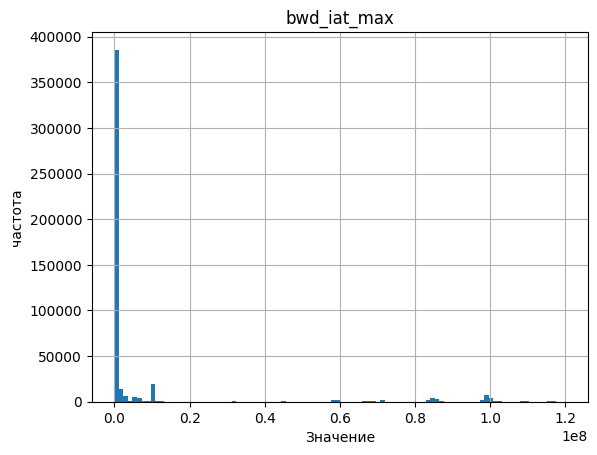

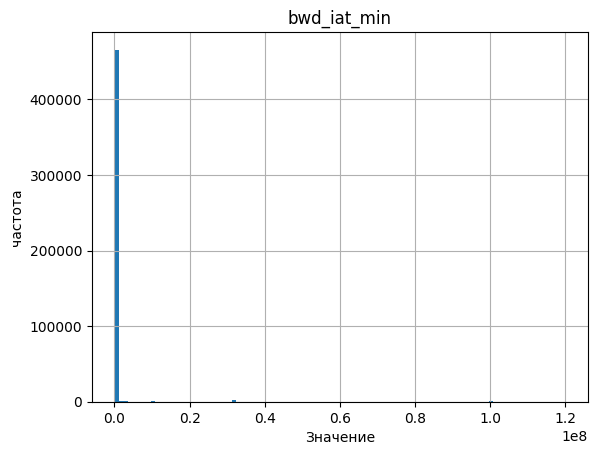

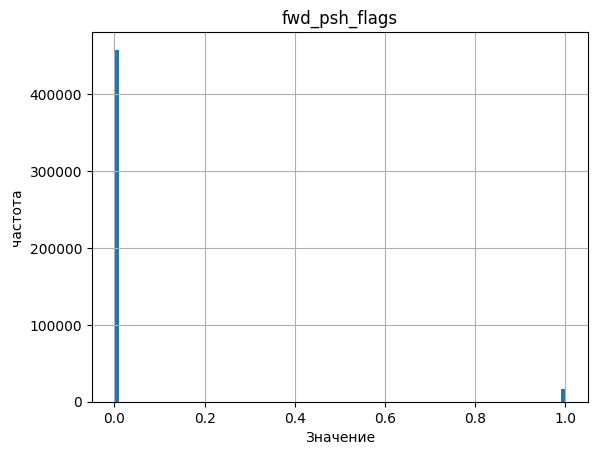

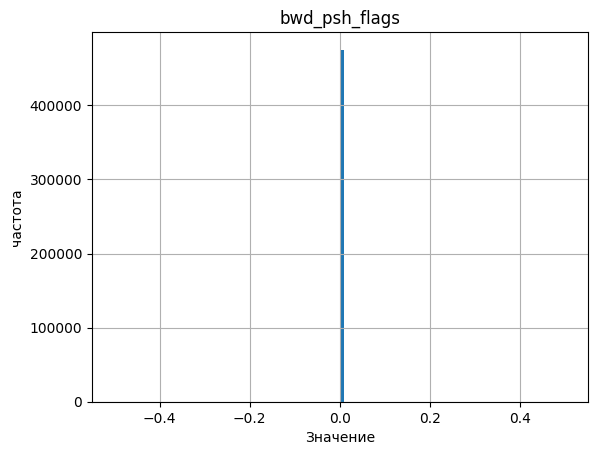

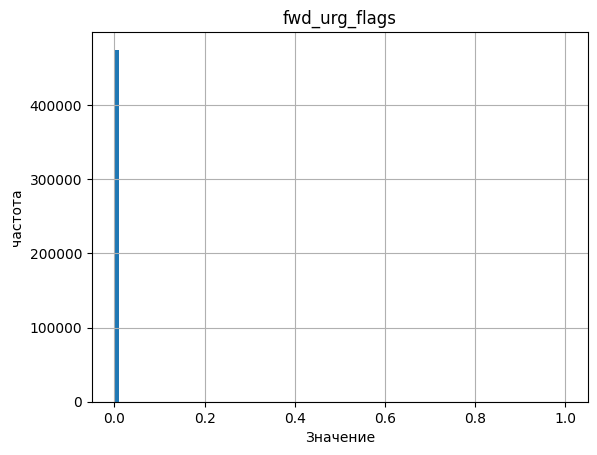

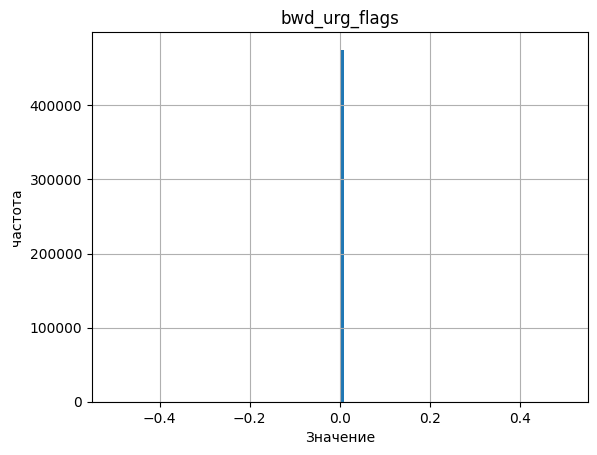

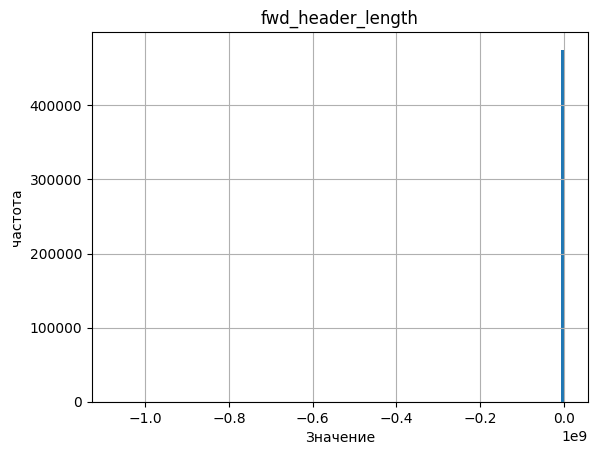

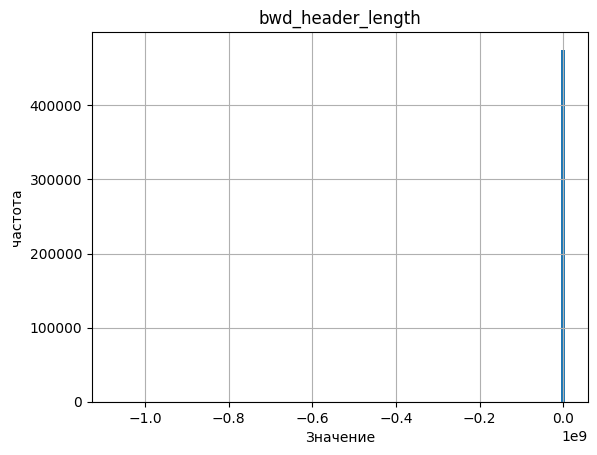

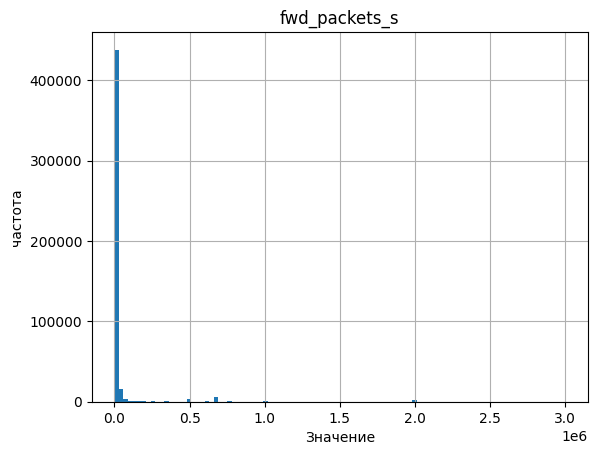

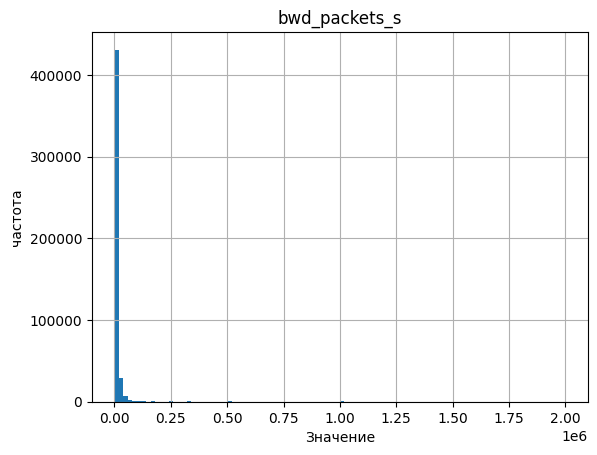

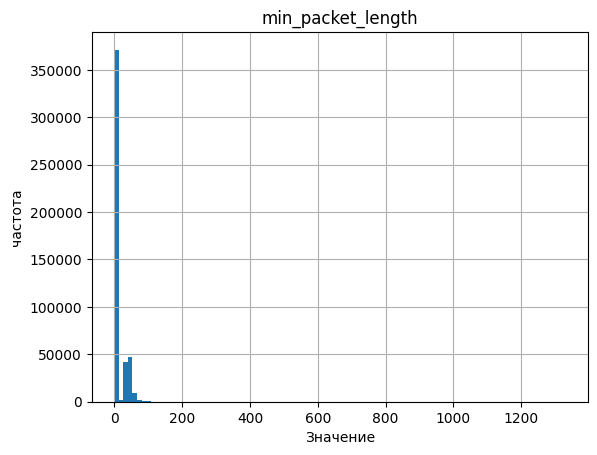

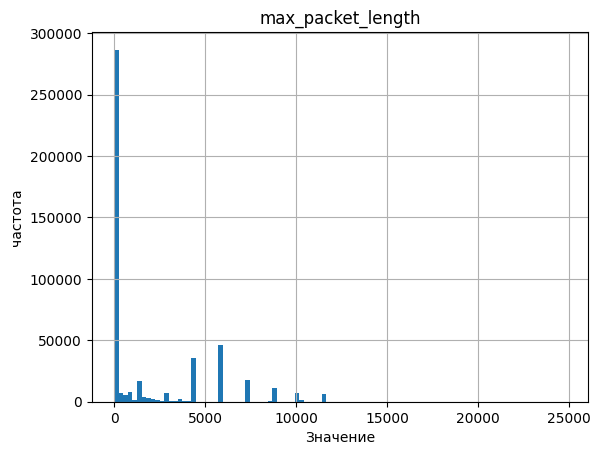

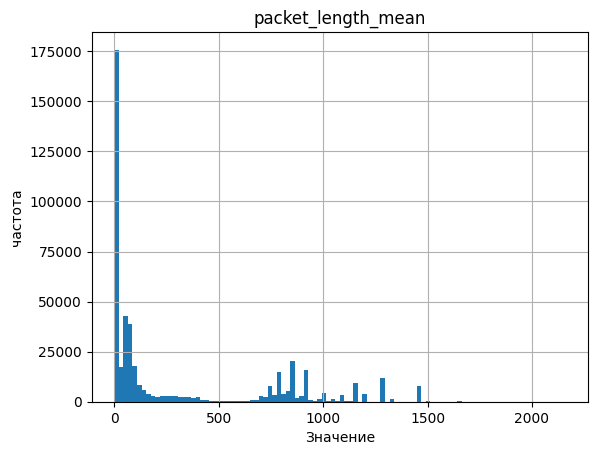

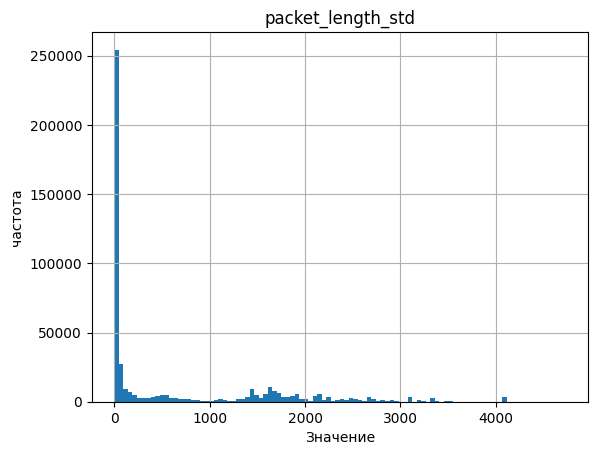

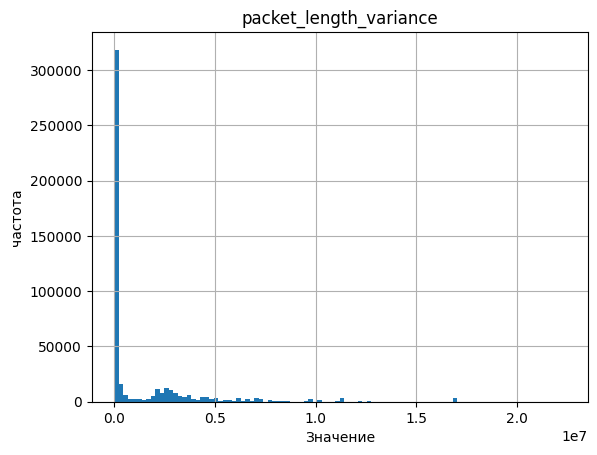

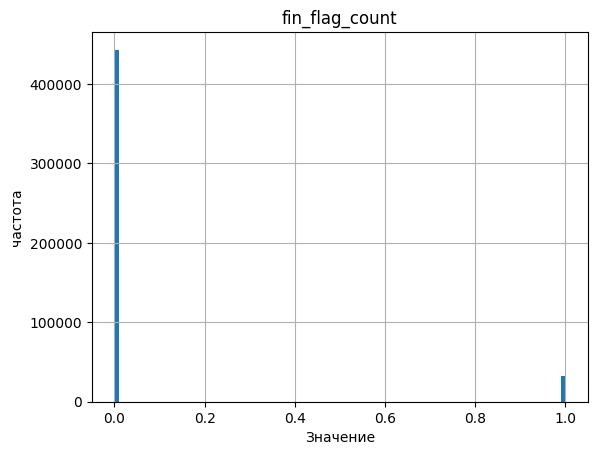

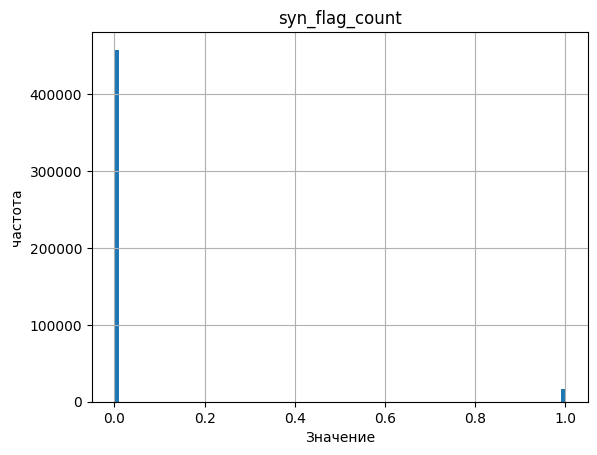

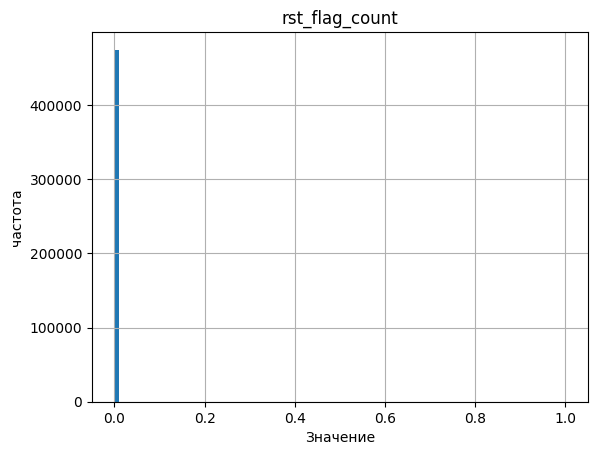

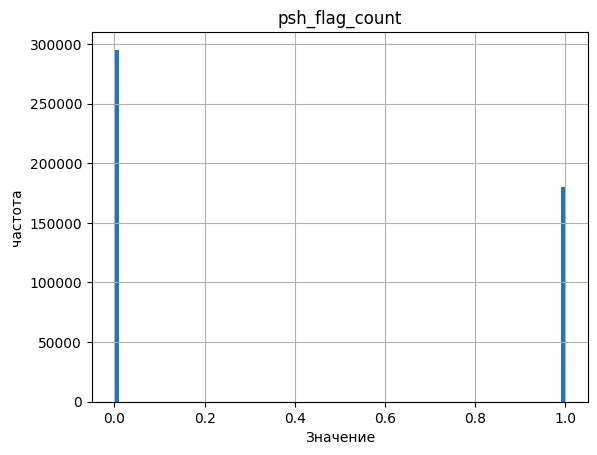

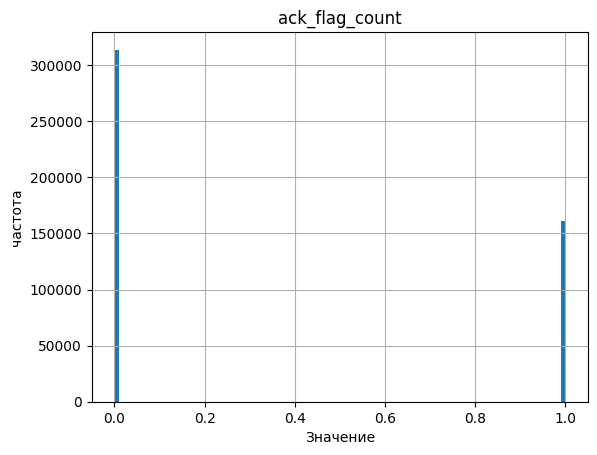

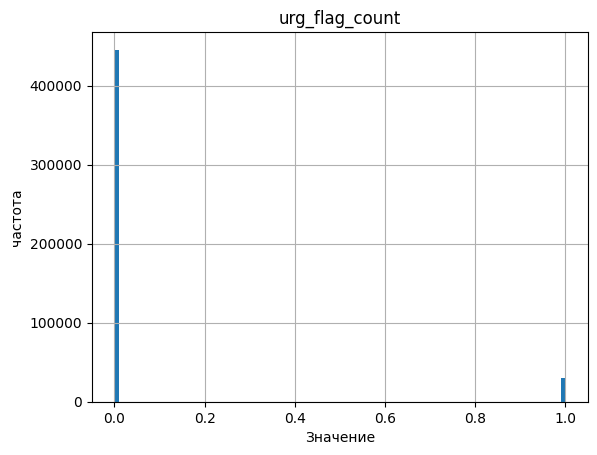

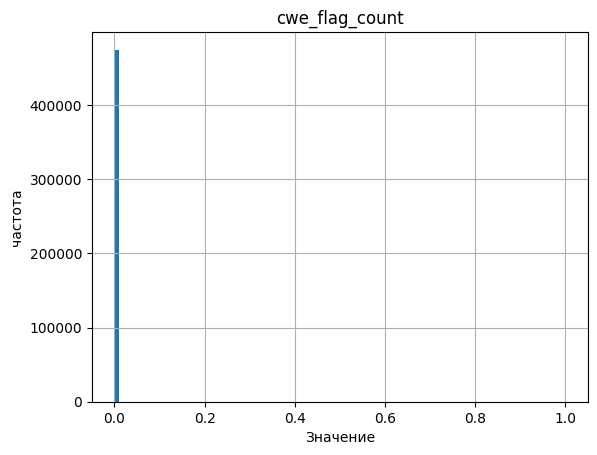

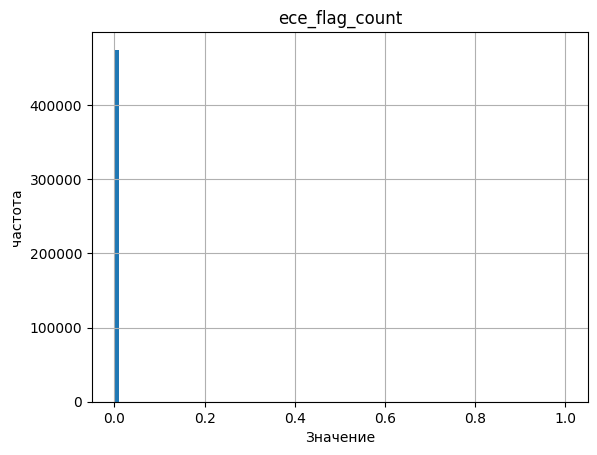

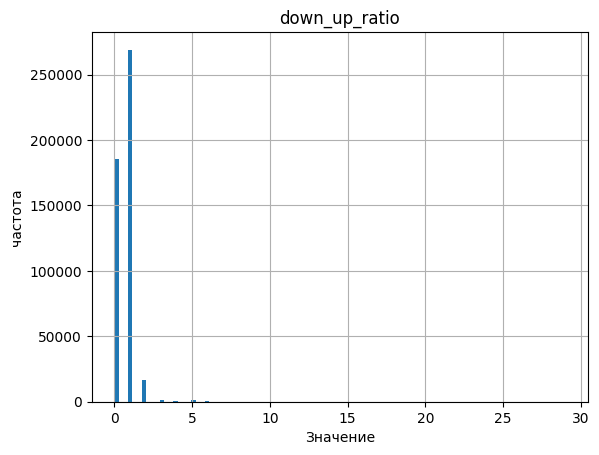

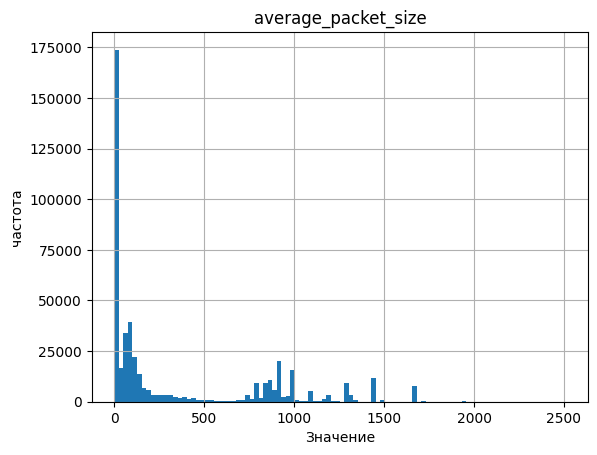

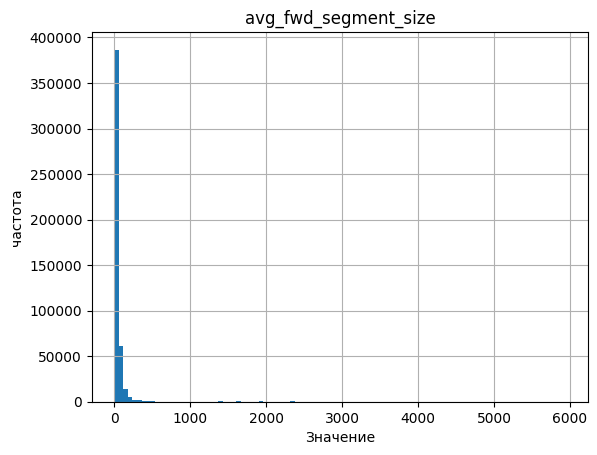

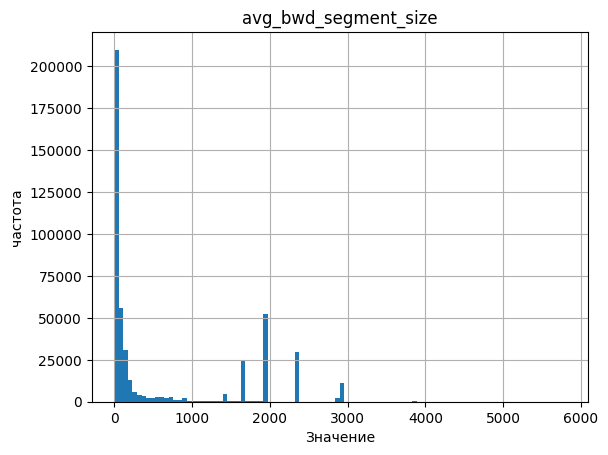

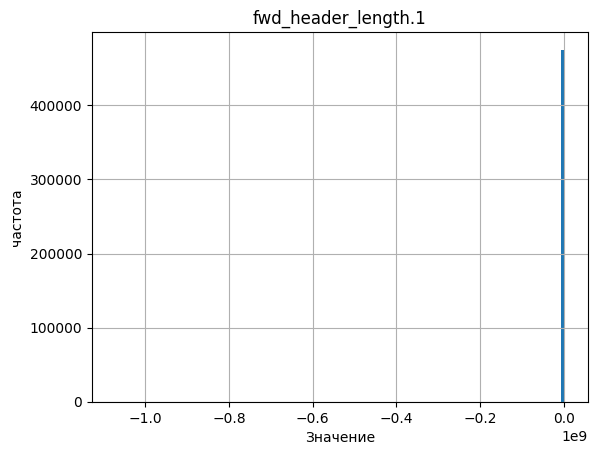

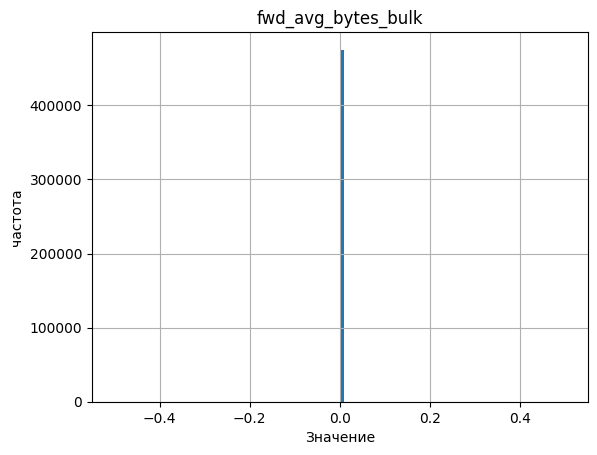

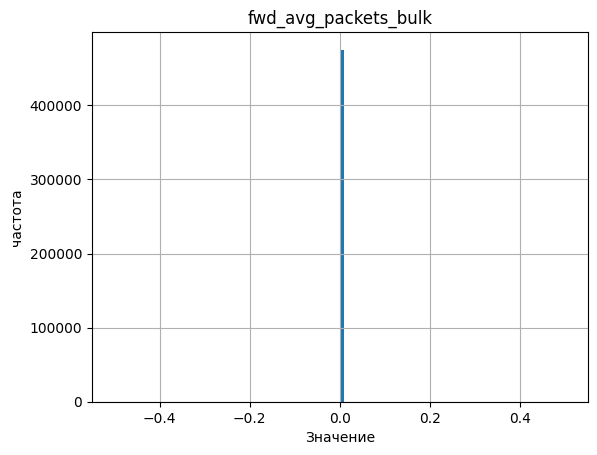

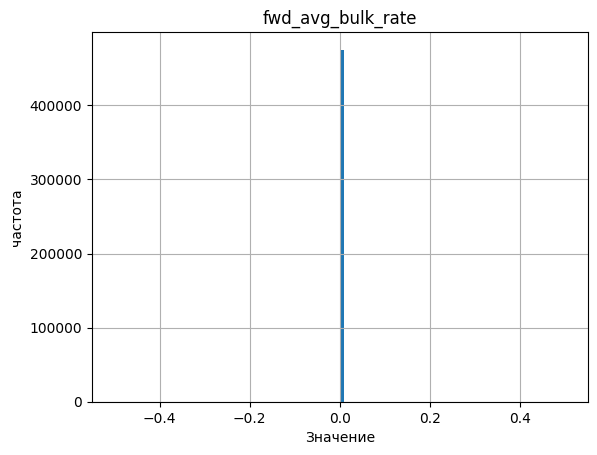

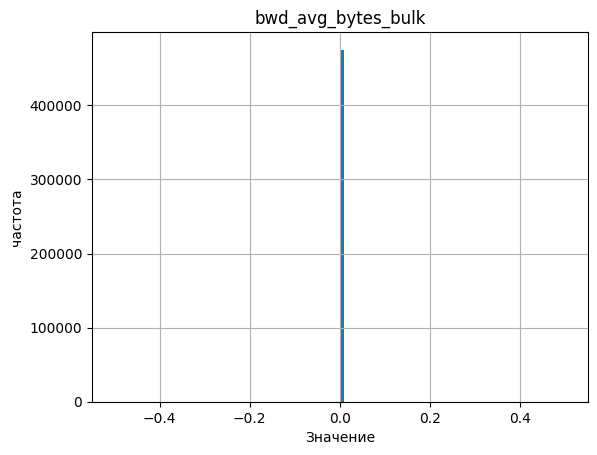

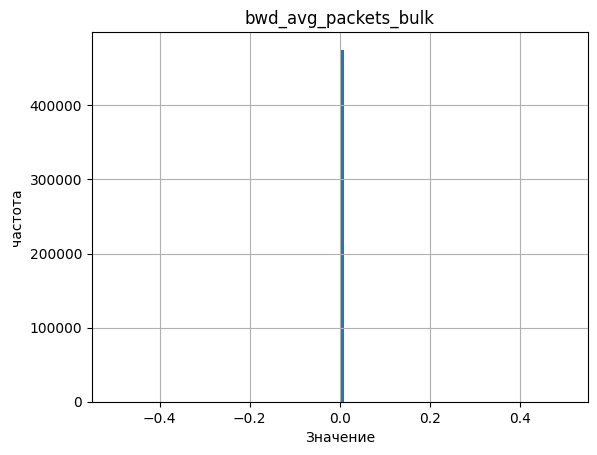

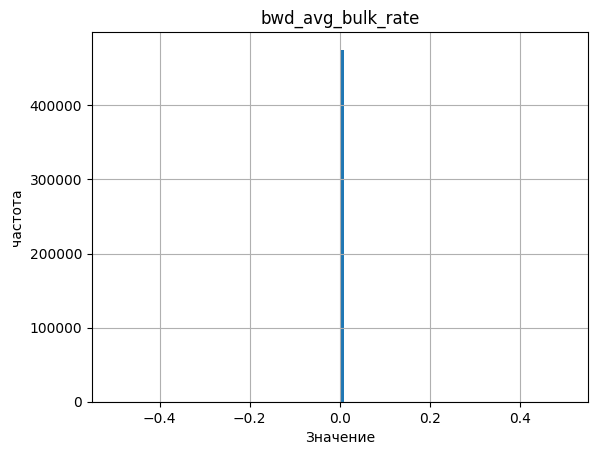

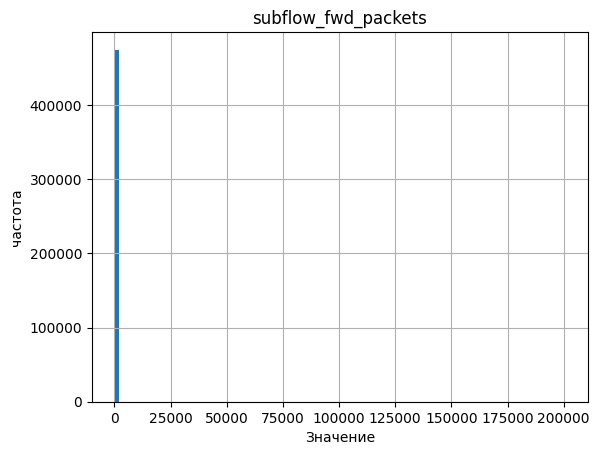

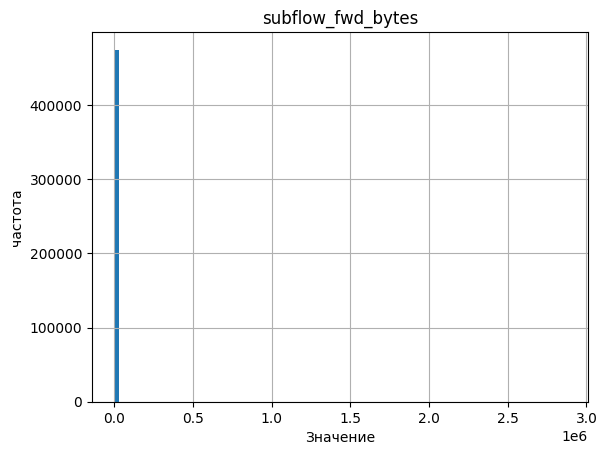

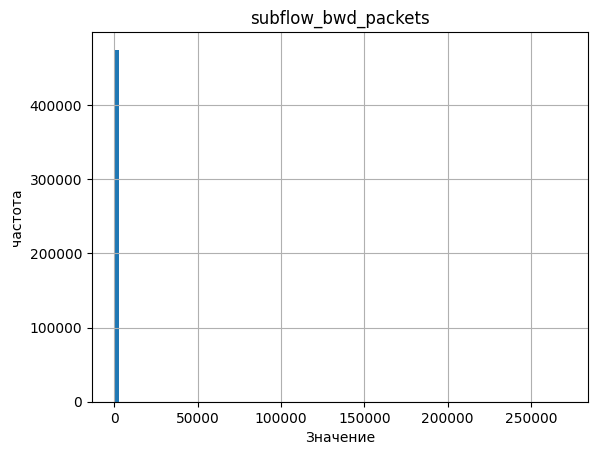

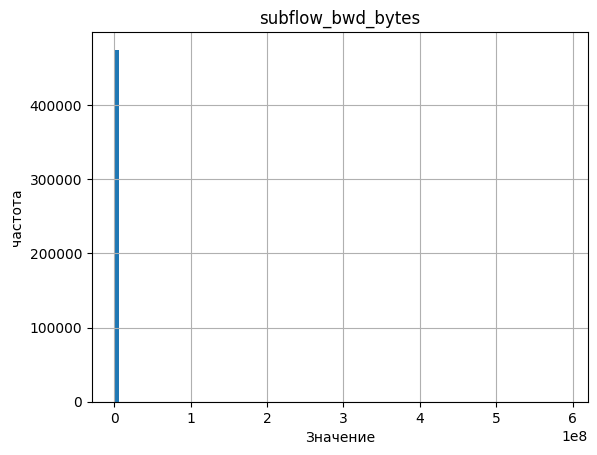

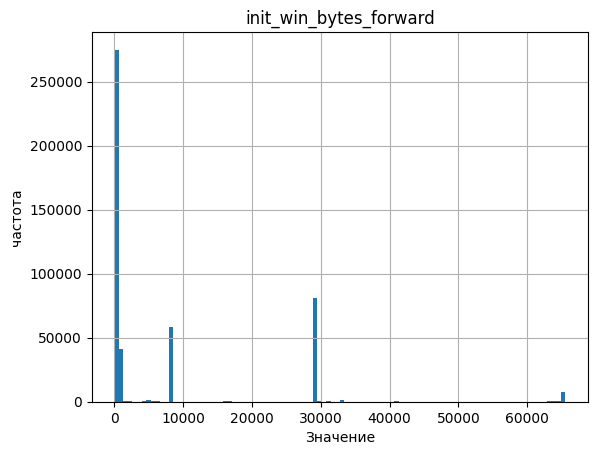

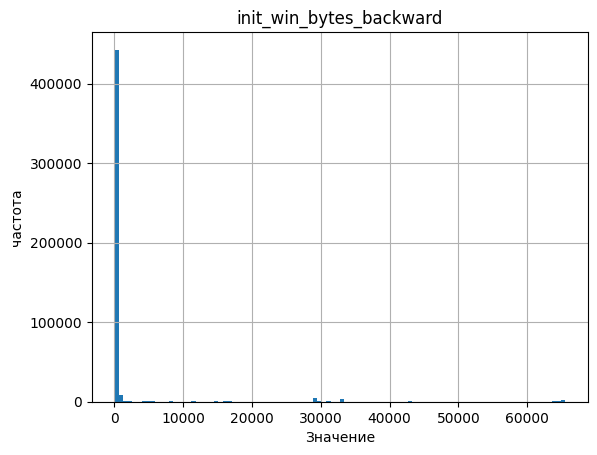

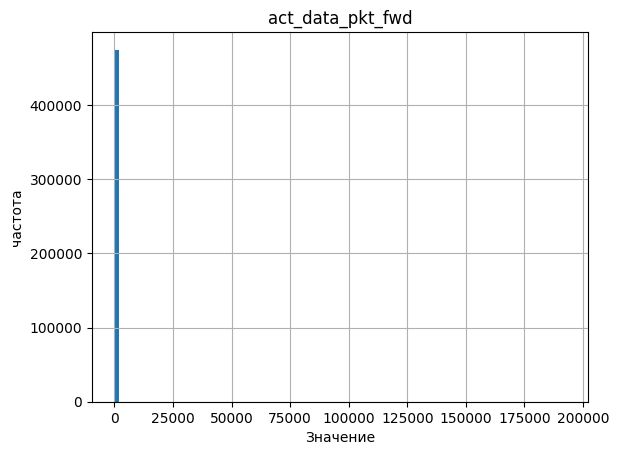

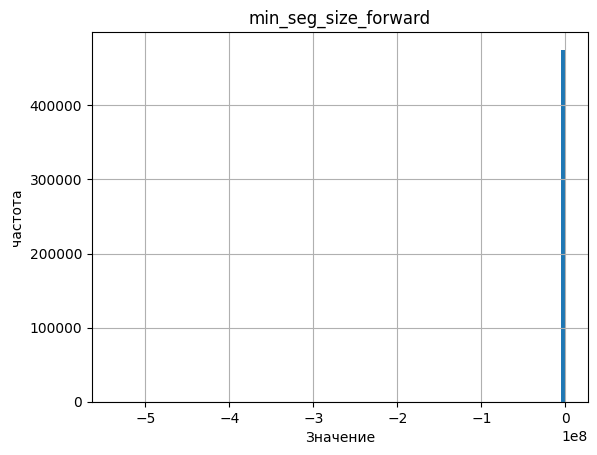

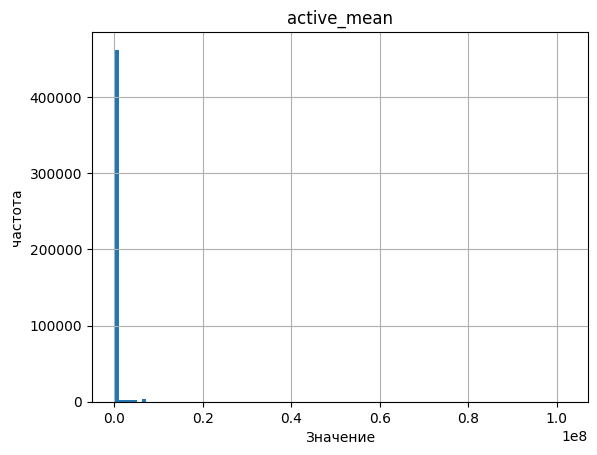

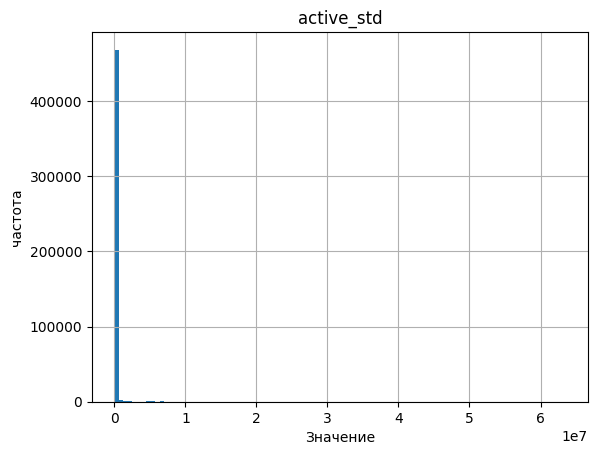

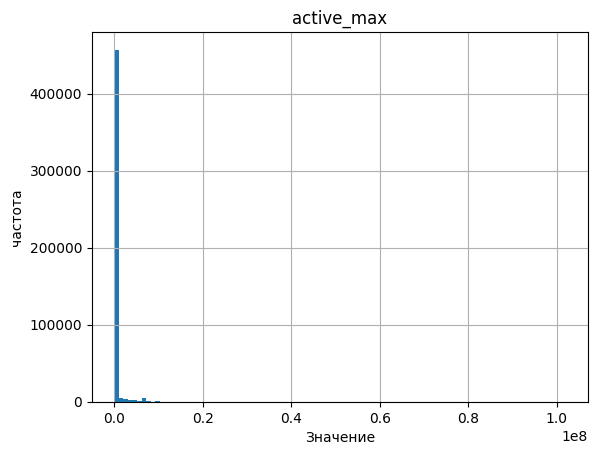

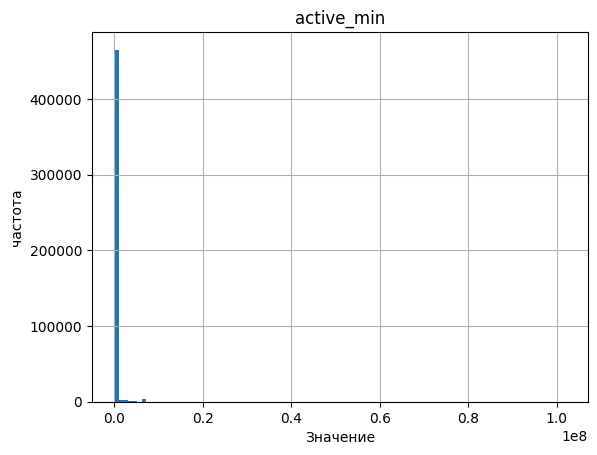

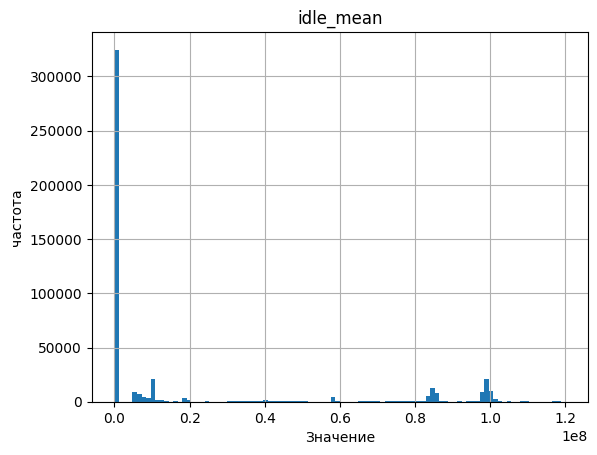

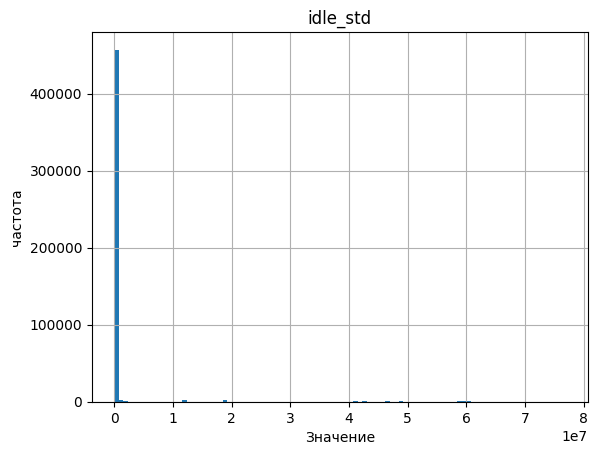

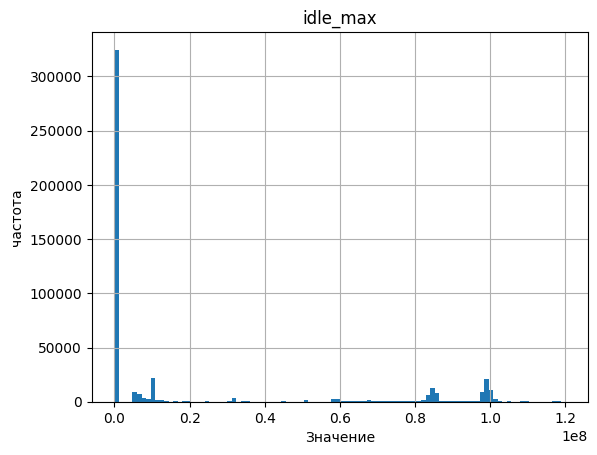

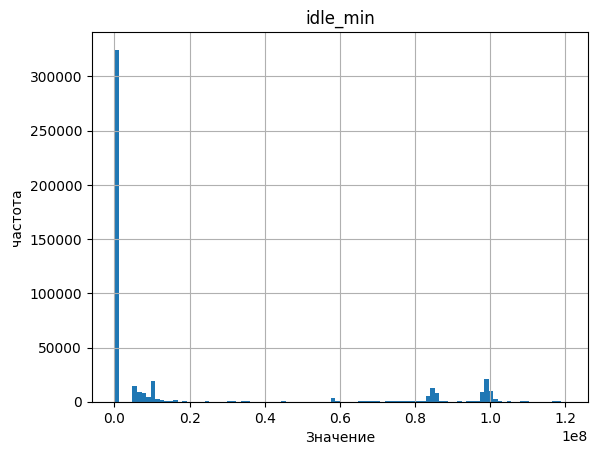

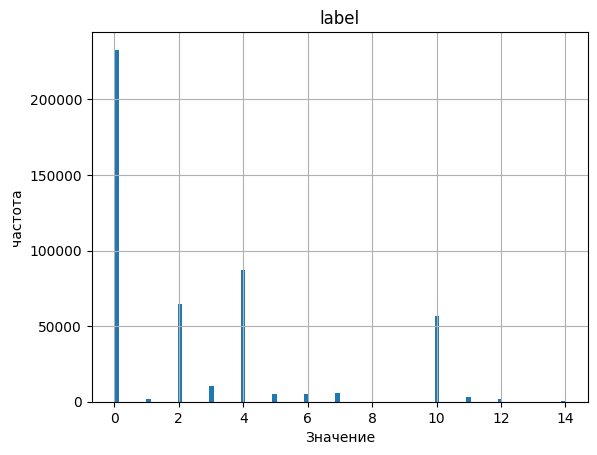

In [15]:
for column in data.columns:
    data_hist(column)

Вывод: анализ графиков, показал, что в данных есть отрицательные значения, а также есть признаки, которые содержат только нулевые значения (bwd_psh_flags, bwd_urg_flags, fwd_avg_bytes_bulk, fwd_avg_packets_bulk, fwd_avg_bulk_rate, bwd_avg_bytes_bulk, bwd_avg_packets_bulk, bwd_avg_bulk_rate).

In [16]:
#удалим данные с нулевыми значениями
for col in data.columns:
    data = data[data[col]>=0]

In [17]:
#удалим данные с нулевыми значениями
data = data.drop(['bwd_psh_flags', 'bwd_urg_flags', 'fwd_avg_bytes_bulk', 'fwd_avg_packets_bulk',
                     'fwd_avg_bulk_rate', 'bwd_avg_bytes_bulk', 'bwd_avg_packets_bulk', 'bwd_avg_bulk_rate', 'bwd_psh_flags'], axis=1)
data.shape

(306061, 71)

**Выводы по исследовательскому анализу данных:** 

- данные успешно выгружены, формат данных верный, названия признаков и классов приведены к необходимому виду
- в столбце Flow Bytes/s выявлены пропущенные значения, удалим их, т.к. составляют меньше 1 %
- выявлены и удалены дубликаты (64601 строк)
- в данных обнаружены бесконечные и отрицательные значения: inf заменены на максимальные, отрицательные удалены
- обнаружены столбцы с нулевыми значениями bwd_psh_flags, bwd_urg_flags, fwd_avg_bytes_bulk, fwd_avg_packets_bulk, fwd_avg_bulk_rate, bwd_avg_bytes_bulk, bwd_avg_packets_bulk, bwd_avg_bulk_rate - для модели в них смысла, их можно удалить
- целевой признак содержит дисбаланс классов, больше всего значений представлено для класса benign, меньше количество для классов: infiltration, web_attack_sql_injection, heartbleed.


## 2. Подготовка данных к обучению

### Корреляция признаков

In [18]:
data.corr()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,bwd_packet_length_max,bwd_packet_length_min,bwd_packet_length_mean,bwd_packet_length_std,flow_bytes_s,flow_packets_s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_total,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_total,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,fwd_urg_flags,fwd_header_length,bwd_header_length,fwd_packets_s,bwd_packets_s,min_packet_length,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,fin_flag_count,syn_flag_count,rst_flag_count,psh_flag_count,ack_flag_count,urg_flag_count,cwe_flag_count,ece_flag_count,down_up_ratio,average_packet_size,avg_fwd_segment_size,avg_bwd_segment_size,fwd_header_length.1,subflow_fwd_packets,subflow_fwd_bytes,subflow_bwd_packets,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
destination_port,1.000000,-0.282804,-0.068155,-0.059078,0.012173,-0.051381,0.083182,0.086832,0.159462,0.100489,-0.361312,0.030549,-0.377255,-0.342850,0.020530,0.019825,-0.224248,-0.249144,-0.252910,-0.005843,-0.279809,-0.197445,-0.241038,-0.251497,-0.030293,-0.146271,-0.099522,-0.106677,-0.110670,-0.038616,0.086203,-0.000749,-0.076868,-0.072949,0.163949,0.155292,0.381258,-0.319660,-0.334291,-0.318365,-0.227688,-0.124426,0.086203,-0.005635,-0.229097,0.325656,0.613661,-0.000749,-0.005635,0.192217,-0.329082,0.159462,-0.377255,-0.076868,-0.068155,0.012173,-0.059078,-0.051389,-0.154448,0.228318,-0.048162,0.042250,-0.054998,-0.049611,-0.065541,-0.037972,-0.245562,-0.038847,-0.246833,-0.239449,-0.148626
flow_duration,-0.282804,1.000000,0.132350,0.100626,0.040740,0.085663,0.192853,-0.033889,0.101206,0.173842,0.441715,-0.068046,0.446156,0.383609,-0.019432,-0.017582,0.763285,0.862640,0.885041,-0.010401,0.999037,0.697548,0.851025,0.885207,0.109519,0.608587,0.388231,0.464236,0.492306,0.136208,-0.036346,-0.001393,0.144588,0.123854,-0.168872,-0.163729,-0.259972,0.448738,0.363294,0.378586,0.186841,0.314071,-0.036346,-0.003725,-0.502076,0.320519,-0.221229,-0.001393,-0.003725,-0.349355,0.341405,0.101206,0.446156,0.144588,0.132350,0.040740,0.100626,0.085676,-0.282349,-0.123142,0.081891,-0.128466,0.156314,0.174494,0.211241,0.089744,0.863792,0.240095,0.883547,0.826769,-0.137119
total_fwd_packets,-0.068155,0.132350,1.000000,0.954623,0.580421,0.794346,0.095695,-0.009286,0.040574,0.047741,0.042397,-0.008459,0.050833,0.006265,-0.004641,-0.004406,0.006055,0.011619,0.033613,-0.003409,0.129973,0.000508,0.013840,0.032768,-0.012443,0.154821,0.010540,0.013784,0.038038,-0.001519,-0.005218,-0.000292,0.973155,0.929600,-0.041333,-0.040404,-0.051031,0.046400,0.062587,0.021768,-0.013864,-0.020546,-0.005218,0.003147,0.037479,-0.027168,-0.058635,-0.000292,0.003147,-0.051690,0.052384,0.040574,0.050833,0.973155,1.000000,0.580421,0.954623,0.794343,0.066015,-0.009269,0.818589,-0.017807,0.171205,0.153756,0.212197,0.117141,0.029588,0.020918,0.032803,0.025727,-0.081754
total_backward_packets,-0.059078,0.100626,0.954623,1.000000,0.483597,0.834318,0.086443,-0.004450,0.030368,0.039234,0.036981,-0.010453,0.049354,-0.002528,-0.003958,-0.003770,-0.016611,-0.012488,0.010679,-0.002927,0.097811,-0.013276,-0.007254,0.009490,-0.011405,0.145811,-0.004722,0.011189,0.040590,-0.012863,-0.010554,-0.000252,0.920366,0.974379,-0.035656,-0.034239,-0.044890,0.040187,0.075273,0.019947,-0.013003,-0.013540,-0.010554,0.001291,0.055077,-0.049980,-0.046599,-0.000252,0.001291,0.015585,0.064983,0.030368,0.049354,0.920366,0.954623,0.483597,1.000000,0.834319,0.067778,-0.012074,0.785827,-0.023416,0.160432,0.133740,0.199022,0.118174,0.009733,0.004557,0.009998,0.008367,-0.074527
total_length_of_fwd_packets,0.012173,0.040740,0.580421,0.483597,1.000000,0.042630,

In [19]:
#найдем признаки с корреляцией, равной 1, и отберем признаки, которые меньше всего коррелируют с целевой переменной
col_list = []
for i in data.columns:
    for j in data.columns:
        if data[i].corr(data[j])==1 and i!=j:
            if data[i].corr(data['label'])<data[j].corr(data['label']):
                col_list.append(i)
            else:
                col_list.append(j)
                

In [20]:
col_list

['subflow_fwd_packets',
 'subflow_bwd_packets',
 'subflow_fwd_bytes',
 'avg_fwd_segment_size',
 'avg_bwd_segment_size',
 'syn_flag_count',
 'cwe_flag_count',
 'fwd_header_length.1',
 'fwd_psh_flags',
 'ece_flag_count',
 'fwd_urg_flags',
 'rst_flag_count',
 'fwd_packet_length_mean',
 'bwd_packet_length_mean',
 'fwd_header_length',
 'total_fwd_packets',
 'total_length_of_fwd_packets',
 'total_backward_packets']

In [21]:
#удалим найденные признаки из датасета
data = data.drop(col_list, axis=1)
data.shape

(306061, 53)

<AxesSubplot:>

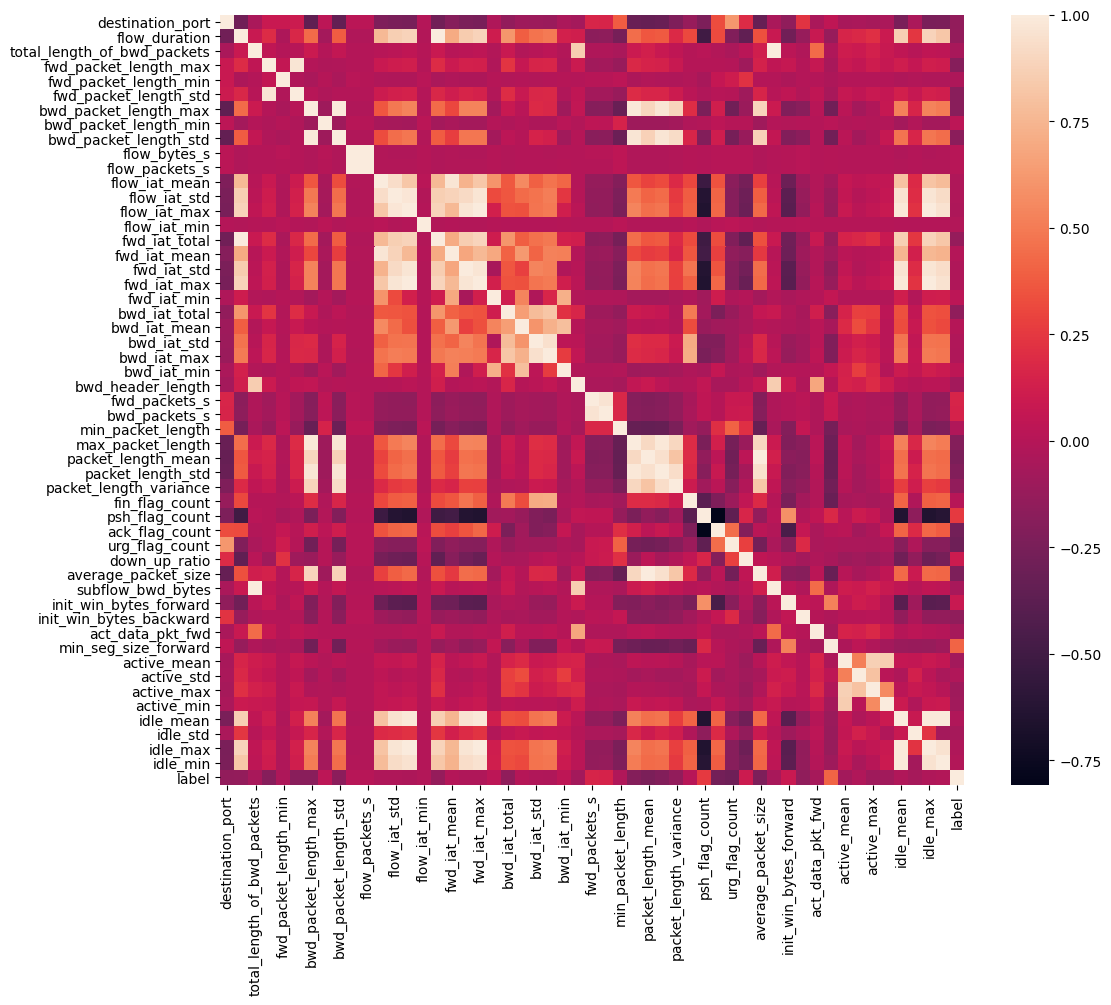

In [41]:
#тепловая карта корреляции по оставшимся признакам
plt.figure(figsize=(12,10))
sns.heatmap(data.corr())

**Вывод:** 
- анализ корреляции признаков показал, что есть дублирующие столбцы, их также удаляем, оставляем те, которые сильнее коррелируют с целевой переменной;
- выявлена мультиколлинеарность признаков;
- с целевой переменной признаки коррелируют слабо, наиболее сильная корреляция с признаком min_seg_size_forward - 0.41.

### Деление на выборки

In [23]:
target = data['label']
features = data.drop('label', axis=1)

In [24]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, stratify=target, random_state=12345)

In [25]:
print(features_train.shape)
print(features_test.shape)

(229545, 52)
(76516, 52)


## 3. Обучение моделей

### LogisticRegression

In [26]:
scalar = StandardScaler()
pipeline = Pipeline([
           ('transformer', scalar),
           ('estimator', LogisticRegression(random_state=12345))
])

accuracy = cross_val_score(pipeline, features_train, target_train, cv=3, scoring='accuracy').mean()
precision = cross_val_score(pipeline, features_train, target_train, cv=3, scoring='precision_weighted').mean()
recall = cross_val_score(pipeline, features_train, target_train, cv=3, scoring='recall_weighted').mean()
f1_score = cross_val_score(pipeline, features_train, target_train, cv=3, scoring='f1_weighted').mean()

print("Accuracy:", accuracy)
print("F1_score:", f1_score)
print("Precision:", precision)
print("Recall:", recall)

C:\Users\Maria Grigorieva\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Maria Grigorieva\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Accuracy: 0.9627916094883355
F1_score: 0.9570589704998574
Precision: 0.9549436239991566
Recall: 0.9627916094883355


C:\Users\Maria Grigorieva\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Метрики модели LogisticRegression:
- Accuracy: 0.9627916094883355
- F1_score: 0.9570589704998574
- Precision: 0.9549436239991566
- Recall: 0.9627916094883355

### RandomForestClassifier

In [27]:
model_forest = RandomForestClassifier(random_state=12345)
params  = {'max_depth': range(5, 12, 2),
        'n_estimators': range(10, 101, 10)}

scoring = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']
gs = GridSearchCV(model_forest, params, n_jobs=-1, cv=3, refit='f1_weighted', verbose=10, scoring = scoring)

gs_cv = gs.fit(features_train, target_train)
best_score = gs_cv.best_score_


print("Tuned CatBoost parameters : {}".format(gs_cv.best_params_))
print("Best score RandomForest:", best_score)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Tuned CatBoost parameters : {'max_depth': 11, 'n_estimators': 10}
Best score RandomForest: 0.9913579256219681


### CatBoostClassifier

In [32]:
model_cat = CatBoostClassifier(random_state=12345)
param_catboost  = {'depth': range(5, 10, 2),
                   'iterations': [100]}
scoring = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']
gs = GridSearchCV(model_cat,param_catboost, n_jobs=-1, cv=3, refit='f1_weighted', verbose=10, scoring = scoring)

gs_cv = gs.fit(features_train, target_train)
best_score = gs_cv.best_score_


print("Tuned CatBoost parameters : {}".format(gs_cv.best_params_))
print("Best score CatBoostRegressor:", best_score)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Learning rate set to 0.5
0:	learn: 0.1262427	total: 4.07s	remaining: 6m 43s
1:	learn: 0.1150881	total: 7.86s	remaining: 6m 25s
2:	learn: 0.0783197	total: 11.7s	remaining: 6m 18s
3:	learn: 0.0589618	total: 15.6s	remaining: 6m 13s
4:	learn: 0.0446495	total: 19.4s	remaining: 6m 9s
5:	learn: 0.0364422	total: 23.2s	remaining: 6m 3s
6:	learn: 0.0320271	total: 27.1s	remaining: 5m 59s
7:	learn: 0.0286292	total: 30.9s	remaining: 5m 55s
8:	learn: 0.0246458	total: 34.9s	remaining: 5m 53s
9:	learn: 0.0230516	total: 38.6s	remaining: 5m 47s
10:	learn: 0.0216631	total: 42.3s	remaining: 5m 42s
11:	learn: 0.0203052	total: 46.1s	remaining: 5m 37s
12:	learn: 0.0191888	total: 49.9s	remaining: 5m 33s
13:	learn: 0.0183307	total: 53.7s	remaining: 5m 29s
14:	learn: 0.0175210	total: 57.5s	remaining: 5m 25s
15:	learn: 0.0171072	total: 1m 1s	remaining: 5m 21s
16:	learn: 0.0169492	total: 1m 4s	remaining: 5m 17s
17:	learn: 0.0161656	total: 1m 8s	remaining:

**Вывод:** 
- обучены 3 модели: логистическая регрессия, случайный лес и кэтбуст
- наилучшую метрику показала модель CatBoostRegressor с гиперпараметрами: depth': 9, 'iterations': 100
- Метрика F1 лучшй модели на обучающей выборке составила 0.9959

## 4. Тестирование лучшей модели

In [45]:
model = gs_cv.best_estimator_
predicted_test = model.predict(features_test)
report = classification_report(target_test, predicted_test)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25000
           1       0.94      0.98      0.96       488
           2       1.00      1.00      1.00     10232
           3       1.00      1.00      1.00      1927
           4       1.00      1.00      1.00     20510
           5       0.99      1.00      1.00       521
           6       1.00      0.99      1.00       937
           7       1.00      1.00      1.00      1466
           8       1.00      1.00      1.00         2
           9       1.00      0.88      0.93         8
          10       1.00      1.00      1.00     14093
          11       1.00      1.00      1.00       801
          12       0.74      0.84      0.78       367
          13       1.00      0.60      0.75         5
          14       0.46      0.31      0.37       159

    accuracy                           1.00     76516
   macro avg       0.94      0.91      0.92     76516
weighted avg       1.00   

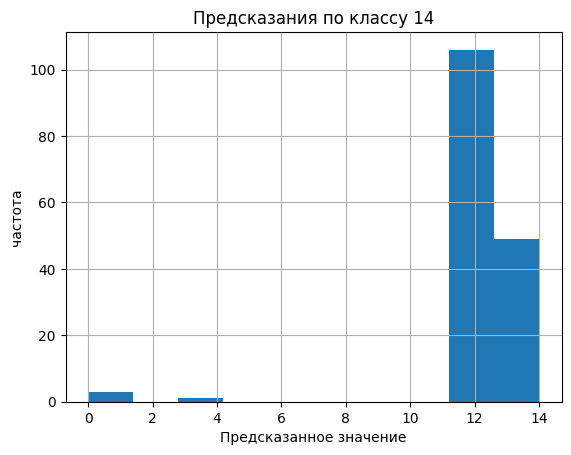

In [60]:
#анализ ошибок для класса 14 (web_attack_xss)
df = pd.DataFrame(target_test, index=target_test.index).join(pd.DataFrame(predicted_test, index=target_test.index))
df.columns = ['test', 'pred']
df[df['test']==14]['pred'].hist(bins=10)
plt.title("Предсказания по классу 14")
plt.xlabel('Предсказанное значение')
plt.ylabel('частота')
plt.show()

**Вывод:** 

Тестирование лучшей модели показало, что модель достаточно точно определяет все классы, кроме 14 (web_attack_xss). 

По графику распределения ошибок для класса 14 можно увидеть, что модель по данному классу в основном дает ответ: 12 (web_attack_brute_force). Для улучшения работы модели возможно необходимо больше данных по типу аттак web_attack_xss.


## 5. Анализ важности факторов

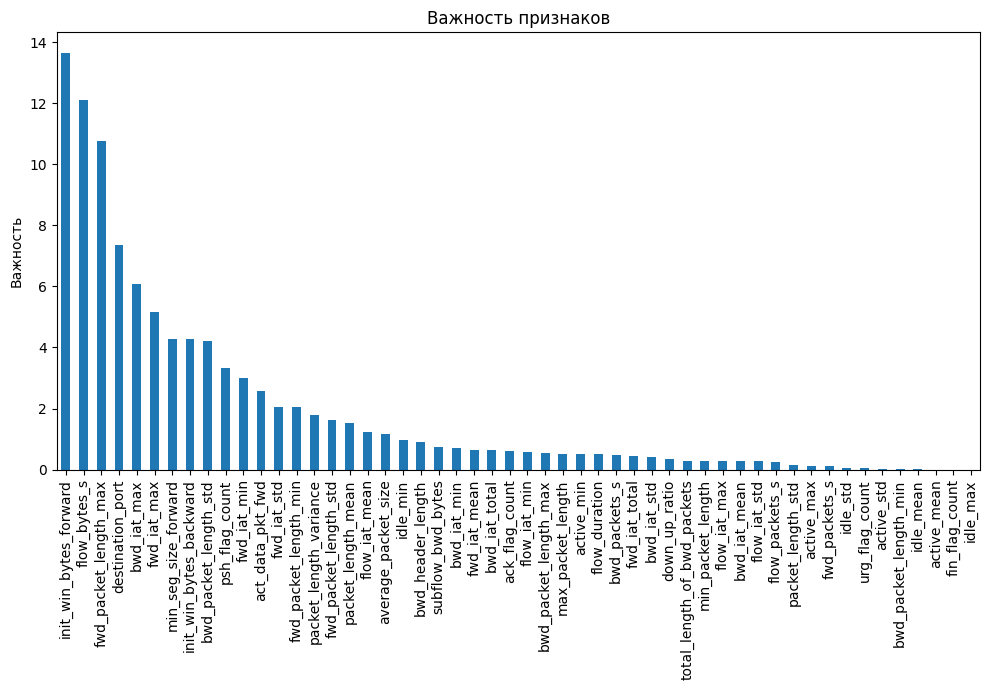

In [61]:
data_importance = pd.Series(model.feature_importances_,
                         features_train.columns)

fig, ax = plt.subplots(figsize=(10,7))
data_importance.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

**Вывод:** рассмотрены факторы, которые сильнее влияют на целевой признак, среди них топ 5:
- 'init_win_bytes_forward'
- 'flow_bytes_s'
- 'fwd_packet_length_max'
- 'destination_port' 
- 'bwd_iat_max'


## Вывод

Проведен исследовательский анализ данных для компании с высоким уровнем входящего трафика с целью разработки модели мультиклассовой классификации для выявления аномального и злонамеренного трафика. 

Проведена предобработка данных: выявлены и обработаны пропуски, дубликаты, аномальные значения. Для модели оставлены ненулевые признаки, удалены дублирующие друг друга признаки. В представленных данных присутствует дисбаланс классов для выявления трафика, для борьбы с ним использованы взвешенные значения метрик.

Рассмотрены и обучены несколько моделей: логистическая регрессия, случайный лес и кэтбуст. Метриками качества выбраны F1, accuracy, recall (полнота), precision (точность). Наилучший показатель у модели CatBoostRegressor с гиперпараметрами: depth': 9, 'iterations': 100. 

Общие метрики лучшей модели для тестовой выборки приближены к 1 для взвешенной величины, для макро составляют: precision - 0.94, recall - 0.91,  f1-score - 0.92. Хуже всего модель определяет класс 14 (web_attack_xss), возможно для улучшения модели нужно больше данных по типу аттак XSS.


Результаты оценки значимости показали сильную взаимосвязь с меткой класса целевого признака следующих признаков: 'init_win_bytes_forward', 'flow_bytes_s', 'fwd_packet_length_max', 'destination_port' и 'bwd_iat_max'.

